In [3]:
ls

bert_imdb.ipynb  cnn_kd.ipynb              kd_lstm_imdb.ipynb   Untitled.ipynb
cnn_imdb.ipynb   kd_atten_lstm_imdb.ipynb  lstm_baseline.ipynb


In [4]:
cd ..

/lustre03/project/6001103/dongxx


In [5]:
cd twitter_baseline

/lustre03/project/6001103/dongxx/twitter_baseline


In [11]:
import config
config.seed_torch()
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe,Vocab,Vectors
from tqdm import tqdm
from utils import Twitter_indexing, pad_sequence,pad_sequencing
from models import CNN_Baseline,LSTMBaseline
from cnn_baseline import validate, prepare_dateset,generate_batch,weight_matrix

import torchtext.vocab
import csv
import pandas as pd
import argparse
import logging
import os
import pickle
import sys
import config
config.seed_torch()
from collections import Counter
import time
import copy

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [13]:
test = '/home/dongxx/projects/def-mercer/dongxx/data140/test.csv'
valid = '/home/dongxx/projects/def-mercer/dongxx/data140/valid.csv'
train ='/home/dongxx/projects/def-mercer/dongxx/data140/train.csv'

In [14]:
counter2 = Counter({'<unk>': 400002, '<pad>': 400001})
glove = Vectors(name='../glove.6B.100d.txt')
f = open('../glove.6B.{}d.txt'.format(100), 'r')
loop = tqdm(f)
vob = {}
loop.set_description('Load Glove')
for i,line in enumerate(loop):
    values = line.split()
    word = values[0]
    vob[word] =400000-i
counter1 = copy.deepcopy(vob)
f.close()
counter1.update(counter2)
vocab = Vocab(counter1)

Load Glove: : 400000it [00:02, 168735.59it/s]


In [15]:
train_dataset, validation_dataset,test_dataset,labellist = prepare_dateset(train, valid,test,vocab)
testing = DataLoader(test_dataset, collate_fn=generate_batch, batch_size=128, shuffle=False)
cnn_model =CNN_Baseline(vocab_size =400002, nKernel = 64, ksz = [3,4,5],number_class = 2)

cnn_model.embedding_layer.weight.data.copy_(weight_matrix(vocab, glove)).to(device)
cnn_model.embedding_layer.weight.data[1] = torch.zeros(100)
cnn_model.embedding_layer.weight.data[0] = torch.zeros(100)
cnn_model.embedding_layer.weight.requires_grad = False
criterion = nn.CrossEntropyLoss()
criterion.to(device)
cnn_model.to(device)
cnn_model.load_state_dict(torch.load(config.MODEL_CNN_PATH_Tittwer))
test_loss, test_acc,flat_list = validate(testing,cnn_model,criterion,device)

Start loading training data
Finish loading training data
Start loading validation data
Finish loading validation data
Start loading testing data
Finish loading testing data
prepare training and test sets


1280000lines [00:39, 32143.08lines/s]
160000lines [00:05, 30593.61lines/s]
160000lines [00:04, 35902.15lines/s]


In [16]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')



Test Loss: 0.415 | Test Acc: 81.45%


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import itertools

In [19]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [20]:
pred_list =[item.cpu().numpy() for sublist in flat_list for item in sublist]

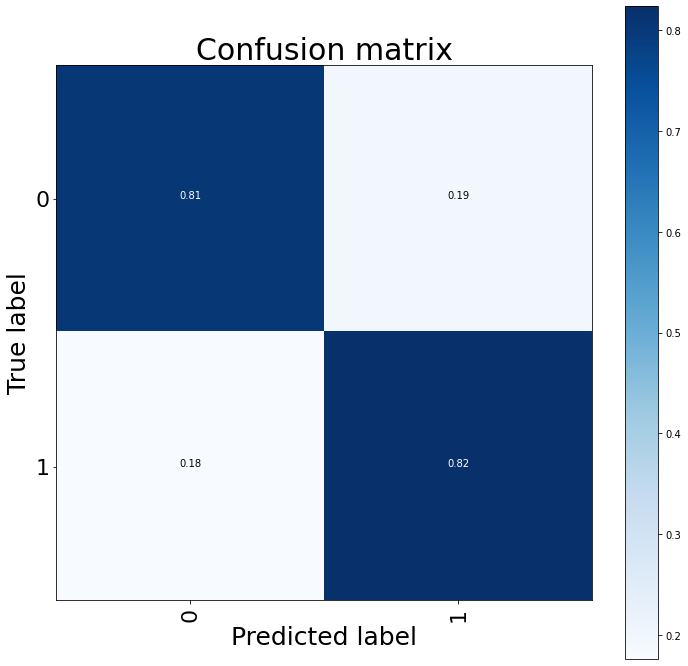

In [21]:
cnf_matrix = confusion_matrix(labellist, pred_list)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=[0,1], title="Confusion matrix")
plt.show()

In [22]:
print(classification_report(labellist, pred_list))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     80000
           1       0.81      0.82      0.82     80000

    accuracy                           0.81    160000
   macro avg       0.81      0.81      0.81    160000
weighted avg       0.81      0.81      0.81    160000

